<a href="https://colab.research.google.com/github/SanjaySaatyaki/fast_ai_try_out/blob/main/tabular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz==1.4.1
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8


In [3]:
!pip install kaggle

In [4]:
creds = '{"username":"sanjaysaatyaki","key":"0532e575ab910ac7a5214493e35e81ae"}'

In [10]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [5]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 34.1k/34.1k [00:00<00:00, 48.2MB/s]

In [6]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

In [54]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,...,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",...,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",...,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",...,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",...,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",...,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",...,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",...,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",...,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",...,111369,30.0000,C148,C


In [55]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [56]:
df.head()

,PassengerId,Survived,Pclass,Name,...,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",...,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",...,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",...,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",...,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",...,373450,8.0500,NaN,S


In [57]:
df.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [58]:
df.fillna(df.mode().iloc[0],inplace=True)

In [59]:
df.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


<Axes: >

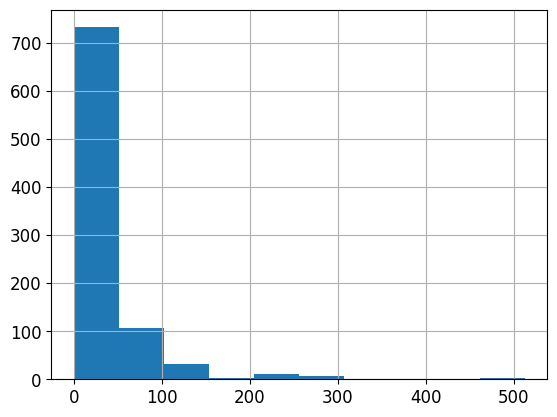

In [60]:
df.Fare.hist()

In [61]:
df['logFare'] = np.log(df['Fare']+1)

<Axes: >

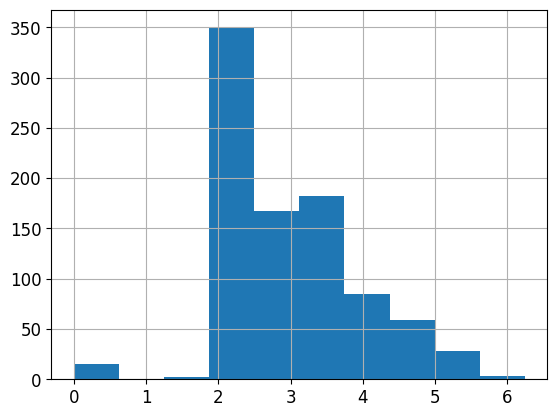

In [62]:
df.logFare.hist()

In [63]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Dooley, Mr. Patrick",male,1601,B96 B98,S
freq,1,577,7,691,646


In [64]:
df = pd.get_dummies(df,columns=['Sex','Pclass','Embarked'])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'logFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [65]:
from torch import tensor

t_dep = tensor(df.Survived)

In [66]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

In [71]:
df.columns.astype(object)

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'logFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [73]:
indep_cols = ['Age', 'SibSp', 'Parch', 'logFare'] + added_cols

# Exclude 'Name', 'Ticket', and 'Cabin' columns, and boolean columns
indep_cols_numeric = [col for col in indep_cols if col in df.columns and df[col].dtype != object and df[col].dtype != bool]

t_indep = tensor(df[indep_cols_numeric].values, dtype=torch.float)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102],
        [38.0000,  1.0000,  0.0000,  4.2806],
        [26.0000,  0.0000,  0.0000,  2.1889],
        [35.0000,  1.0000,  0.0000,  3.9908],
        [35.0000,  0.0000,  0.0000,  2.2028],
        [24.0000,  0.0000,  0.0000,  2.2469],
        [54.0000,  0.0000,  0.0000,  3.9677],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857],
        [39.0000,  0.0000,  5.0000,  3.4054],
        [27.0000,  0.0000,  0.0000,  2.6391],
        [19.0000,  0.0000,  0.0000,  3.4340],
        [24.0000,  1.0000,  2.0000,  3.1966],
        [26.0000,  0.0000,  0.0000,  3.4340],
        [32.0000,  0.0000,  0.0000,  2.1691]])